# TF Hub Flowers

Extract features with all of the tfhub models on the cropped FLIR dataset and compute/plot the TSNE of those features.

In [1]:
import itertools
import os
from pathlib import Path

import matplotlib.pylab as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

from sklearn.manifold import TSNE

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
# print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

print(f"GPU is available: {tf.test.is_built_with_cuda()}")
print(f"GPU device: {tf.config.list_physical_devices('GPU')}")

results_dir = Path("../work/results/flowers")

activations_dir = results_dir.joinpath("activations")
tsne_dir = results_dir.joinpath("tsne")
plots_dir = results_dir.joinpath("plots")


# data_dir = Path("../work/data/flir/cropped/train")
# data_dir = Path("../work/data/flir/cropped").joinpath(data_mode)

data_dir = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

print(f"Results: {results_dir}")
print(f"Activations: {activations_dir}")
print(f"Plots: {plots_dir}")
print(f"TSNE: {tsne_dir}")
print(f"Data: {data_dir}")

activations_dir.mkdir(parents=True, exist_ok=True)
plots_dir.mkdir(parents=True, exist_ok=True)
tsne_dir.mkdir(parents=True, exist_ok=True)

TF version: 2.6.0
Hub version: 0.12.0
GPU is available: True
GPU device: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Results: ..\work\results\flowers
Activations: ..\work\results\flowers\activations
Plots: ..\work\results\flowers\plots
TSNE: ..\work\results\flowers\tsne
Data: C:\Users\Sasha\.keras\datasets\flower_photos


## Declare all of the model names and input dimensions

In [2]:
# model_name = "mobilenet_v3_small_100_224"  # @param ['bit_s-r50x1', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'inception_v3', 'inception_resnet_v2', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152']

model_handle_map = {
    "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
    # "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1",
    # "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/feature-vector/1",
    # "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1",
    # "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1",
    # "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/feature-vector/1",
    # "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1",
    # "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
    # "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/1",
    # "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature-vector/4",
    # "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature-vector/4",
    # "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature-vector/4",
    # "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/feature-vector/4",
    # "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature-vector/4",
    # "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature-vector/4",
    # "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature-vector/4",
    # "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature-vector/4",
    # "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4",
    # "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4",
    # "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/4",
    # "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
    # "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
    # "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
    # "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
    # "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5",
    # "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
    # "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5",
}

model_image_size_map = {
    "efficientnet_b0": 224,
    "efficientnet_b1": 240,
    "efficientnet_b2": 260,
    "efficientnet_b3": 300,
    "efficientnet_b4": 380,
    "efficientnet_b5": 456,
    "efficientnet_b6": 528,
    "efficientnet_b7": 600,
    "inception_v3": 299,
    "inception_resnet_v2": 299,
    "nasnet_large": 331,
    "pnasnet_large": 331,
}

## Iterate over all models

Selected model: efficientnet_b0 : https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1
Input size (224, 224)
Found 3670 images belonging to 5 classes.
Generator shape 0: (32, 224, 224, 3)
Generator shape 1: (32, 5)
Building model with https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1
Conducting inference...
Completed inference: (3670, 1280)
Calculating tsne...


C:\Users\Sasha\Anaconda3\envs\deepart2\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Sasha\Anaconda3\envs\deepart2\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Calculated tsne: (3670, 2)
Saving activations
Saving TSNE


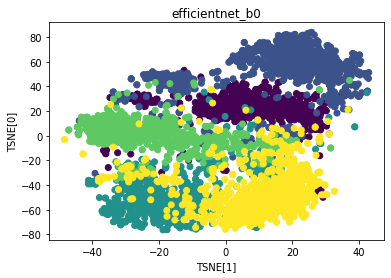

In [6]:
# Iterate over all models
for model_name, model_handle in model_handle_map.items():
    try:
        # Declare the savenames, etc. for if we're passing
        data_save_name = activations_dir.joinpath(model_name + ".h5")
        plot_save_name = plots_dir.joinpath(model_name + ".jpg")
        tsne_save_name = tsne_dir.joinpath(model_name + ".h5")

        # Skip this iteration if we already ran it
        if data_save_name.exists() and plot_save_name.exists() and tsne_save_name.exists():
            print(f"--- SKIPPING: {model_name}")
            continue

        # Show the selected model and handle
        print(f"Selected model: {model_name} : {model_handle}")
        # Get the square dimension, defaulting to 224
        pixels = model_image_size_map.get(model_name, 224)
        IMAGE_SIZE = (pixels, pixels)
        BATCH_SIZE = 32
        print(f"Input size {IMAGE_SIZE}")

        # Get the data generator
        datagen_kwargs = dict(
            rescale=1./255
        )
        dataflow_kwargs = dict(
            target_size=IMAGE_SIZE,
            batch_size=BATCH_SIZE,
            interpolation="bilinear",
            shuffle=False
        )
        train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
        train_generator = train_datagen.flow_from_directory(data_dir, **dataflow_kwargs)
        print(f"Generator shape 0: {np.shape(next(train_generator)[0])}")
        print(f"Generator shape 1: {np.shape(next(train_generator)[1])}")
        len(f"Number of classes: {np.shape(train_generator.classes)}")

        # Build the model
        print("Building model with", model_handle)
        model = tf.keras.Sequential([
            # Explicitly define the input shape so the model can be properly
            # loaded by the TFLiteConverter
            tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
            hub.KerasLayer(model_handle)
        ])
        model.build((None,)+IMAGE_SIZE+(3,))
        # model.summary()
        
        # Get the predicted features
        print(f"Conducting inference...")
        results = model.predict(train_generator)
        print(f"Completed inference: {np.shape(results)}")
        
        # Compute the TSNE
        print(f"Calculating tsne...")
        tsne = TSNE().fit_transform(results)
        print(f"Calculated tsne: {np.shape(tsne)}")
        
        # Plot with masking
        plt.figure()
        plt.ylabel("TSNE[0]")
        plt.xlabel("TSNE[1]")
        plt.title(model_name)
        plt.scatter(tsne[:, 0], tsne[:, 1], c = train_generator.classes)
        
        # Save the plot
        plt.savefig(plot_save_name)

        # Save the activations
        print(f"Saving activations")
        df = pd.DataFrame(results)
        df.to_hdf(data_save_name, 'df', mode='w')

        # Save the labels
        cl = pd.DataFrame(train_generator.classes)
        cl.to_hdf(data_save_name, 'classes', mode='a')

        # Save the TSNE
        print(f"Saving TSNE")
        df = pd.DataFrame(tsne)
        df.to_hdf(tsne_save_name,'df', mode='w')
    except Exception as e:
        print(f"--- FAILURE: {model_name}")
        print(e)

In [4]:
# cl = pd.DataFrame(train_generator.classes)
# cl.to_csv(activations_dir.joinpath('classes.csv'),index=False, mode='w')
# np.shape(train_generator.classes)